<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 1)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: k-mer Representation with Frequency Analysis
   - Break the DNA sequence into k-mers (subsequences of length k).
   - Perform frequency analysis to create a feature vector based on the occurrence of each k-mer.
   - Use this feature vector as input to the model.

3. **Pros**:
   - Captures local context within each k-mer.
   - Simplifies the input representation by reducing it to frequency counts.

4. **Cons**:
   - Loses positional information beyond the k-mer length.
   - Treating it as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model ignores the order of k-mers.
   - Depending on the k value chosen, k-mer representation can lead to high-dimensional features.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Feature processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier

# Metric and utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import zscore

# Warning
import warnings
warnings.filterwarnings("ignore")

# to save model
import joblib
import itertools

In [31]:
def kmer_count(sequence, k=3, step=1):
    """
    Utils: to count kmer occurence in DNA sequence and compute frequence
    """
    kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]
    kmers_count = {kmer: 0 for kmer in kmers}
    s = 0
    for i in range(0, len(sequence) - k + 1, step):
        kmer = sequence[i:i + k]
        s += 1
        #kmers_count[kmer] += 1
        if kmer in kmers_count:
            kmers_count[kmer] += 1
        #else:
        #    kmers_count[kmer] = 1
    for key, value in kmers_count.items():
        kmers_count[key] = value / s

    return kmers_count

In [32]:
def read_fasta_file(file_path, family):
    """
    Utils: Convert fasta file to dataframe
    """
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

In [33]:
def build_kmer_representation(df, k=3):
    """
    Utils: For given k-mer generate dataset and return vectorised version
    """
    sequences   = df['sequence']
    kmers_count = []
    for i in range(len(sequences)):
        kmers_count.append(kmer_count(sequences[i], k=k, step=1))
        
    v = DictVectorizer(sparse=False)
    feature_values = v.fit_transform(kmers_count)
    feature_names = v.get_feature_names_out()
    X = pd.DataFrame(feature_values, columns=feature_names)
    y = df['class']
    return X, y

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [34]:
#dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset_ = pd.read_csv("./Output/kiwi_orange_cds.csv")

# Split
dataset, testset = train_test_split(dataset_, test_size=0.2, stratify=dataset_["class"], random_state=42)
dataset = dataset.reset_index(drop=True)
testset = testset.reset_index(drop=True)

# Get a look
dataset.head()

,id,sequence,length,class
0,orange1.1g020389m Citrus sinensis,ATGGTATCAAAAATCCCGAACCCGGCAGAAGGATTCTACTTGGATC...,984,0
1,orange1.1g046419m Citrus sinensis,ATGCTGTTGGGGAACAGCAACGGAGAGCAACTGGAAAGCGGGGTTG...,1518,0
2,orange1.1g007034m Citrus sinensis,ATGATGATGAGTTTTGATGAGATGGGGTTTTGTGGTGACATGAACT...,1866,0
3,Achn378631 Actinidia chinensis,ATGGCAGGTTTTGAAATGGCAGGGGAACCCAAGATTGATGAGGTAA...,783,1
4,Achn155941 Actinidia chinensis,ATGCCCAATTTCATTCCAACAGTTGTGTTTGTTGCTCCTCACCTCA...,777,1


### 3 - Model Utils
Instead of taking each base as an individual feature, we transform DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tranformed into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: **3, 4, 5, and 6**.

**Notes:** <span style="color:red;">We are going to try to do our prediction with these models.</span> For each k-mer dataset we'll fine tune each of these model to find the best parameters then we do cross-validation to assess their accuracy.

In [35]:
param_grids = {
    "Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "XGBClassifier": {'n_estimators':[2, 3, 5, 10, 20, 100, 200], 'max_depth':[2, 3, 5, 7]},
    "Gaussian Process": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]},
    "Random Forest": {'max_depth': [3, 5, 7], 'n_estimators': [10, 50, 100], 'max_features': [1, 2, 3]},
    "AdaBoost": {'n_estimators': [50, 100, 200]},
    "Naive Bayes": {},
    "SVM Linear": {'C': [0.1, 1, 10]},
    "SVM RBF": {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]},
}
names = [
    "Nearest Neighbors", "XGBClassifier", "Gaussian Process", "Random Forest", "AdaBoost", 
    "Naive Bayes", "SVM Linear", "SVM RBF"
]
def init_model():
    """
    Utils: This Define the hyperparameter grids and a list of model we are going to try
    """
    classifiers = [
        KNeighborsClassifier(),
        XGBClassifier(objective='binary:logistic'),
        GaussianProcessClassifier(),
        RandomForestClassifier(),
        AdaBoostClassifier(algorithm="SAMME"),
        GaussianNB(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
    ]
    models = zip(names, classifiers)
    return models

def train_eval(models, X_train, y_train, X_test, y_test):
    """
    Utils: to train and eval models
    """
    best_parameters = []
    history = {
        'train_time': [],
        'train_score': [],
        'train_score_std': [],
        'test_score': []
    }
    fb_model_name = None
    fb_model = None
    fb_score = 0
    
    for name, model in models:
        print(f"Processing {name}...")
        param_grid = param_grids[name]
        kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        
        # Perform grid search & Get the best model
        grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        training_time = time.time() - start_time
        history['train_time'].append(training_time)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_parameters.append((name, best_params))
        print('Best params found: ', best_params)
        
        # Cross-validation results
        cv_results = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='accuracy')
        msg = "[Train] - '{}' - cross_val acc: {} ±({})".format(name, cv_results.mean(), cv_results.std())
        print("{}\n{}\n{}".format('-'*80, msg, '-'*80))
        history['train_score'].append(cv_results.mean())
        history['train_score_std'].append("±"+str(cv_results.std()))
        
        # Fit the best model
        best_model.fit(X_train, y_train)
        if cv_results.mean() > fb_score:
            fb_score = cv_results.mean()
            fb_model = best_model
            fb_model_name = name
        
        # Make predictions on test set and print results
        predictions = best_model.predict(X_test)
        print("[Test]  - '{}' - testset acc : {}".format(name, accuracy_score(y_test, predictions)))
        history['test_score'].append(accuracy_score(y_test, predictions))
        print(classification_report(y_test, predictions), end="\n")

    # Dump model
    #joblib.dump(fb_model, f'./Output/ModelPickle/k{k}_[{fb_model_name}]_basic.joblib')
    return history

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [36]:
k = 3
X_3_train, y_train = build_kmer_representation(dataset, k=k)
X_3_test, y_3_test = build_kmer_representation(testset, k=k)
X_3_train.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.027495,0.019348,0.026477,0.020367,0.016293,0.019348,0.009165,0.011202,0.023422,0.016293,...,0.009165,0.015275,0.022403,0.017312,0.018330,0.010183,0.010183,0.019348,0.014257,0.011202
1,0.017150,0.033641,0.022427,0.023747,0.025066,0.015831,0.010554,0.018470,0.013852,0.020449,...,0.009894,0.020449,0.015172,0.016491,0.010554,0.008575,0.007916,0.027704,0.015831,0.019129
2,0.018240,0.015021,0.033798,0.019850,0.017167,0.009657,0.004292,0.008584,0.025215,0.018777,...,0.008047,0.017704,0.032189,0.013412,0.024678,0.018777,0.011803,0.015558,0.020923,0.018777
3,0.037132,0.012804,0.024328,0.035851,0.014085,0.015365,0.002561,0.012804,0.025608,0.005122,...,0.000000,0.011524,0.026889,0.012804,0.029449,0.012804,0.014085,0.011524,0.038412,0.034571
4,0.027097,0.019355,0.021935,0.029677,0.019355,0.015484,0.000000,0.006452,0.019355,0.014194,...,0.015484,0.016774,0.012903,0.012903,0.015484,0.019355,0.012903,0.024516,0.018065,0.018065


In [37]:
y_train.head()

0    0
1    0
2    0
3    1
4    1
Name: class, dtype: int64

* Let <span style="color:red">tune</span> our differents model and <span  style="color:red">assess</span> their performance

In [38]:
models = init_model()
history_k3  = train_eval(models, X_3_train, y_train, X_3_test, y_3_test)

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - cross_val acc: 0.7936813186813186 ±(0.033477053008451316)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - testset acc : 0.7892425905598244
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       451
           1       0.76      0.85      0.80       460

    accuracy                           0.79       911
   macro avg       0.79      0.79      0.79       911
weighted avg       0.79      0.79      0.79       911

Processing XGBClassifier...
Best params found:  {'max_depth': 5, 'n_estimators': 200}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - cross_val acc: 0.8538461538461538 ±(0.02343392100234739)
---------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [39]:
k = 4
X_4_train, y_train = build_kmer_representation(dataset, k=k)
X_4_test, y_4_test = build_kmer_representation(testset, k=k)
X_4_train.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.010194,0.007136,0.008155,0.002039,0.007136,0.006116,0.003058,0.003058,0.008155,0.004077,...,0.002039,0.006116,0.010194,0.001019,0.002039,0.001019,0.002039,0.003058,0.004077,0.002039
1,0.003960,0.003960,0.003960,0.005281,0.015182,0.003300,0.004620,0.010561,0.007261,0.007921,...,0.002640,0.009241,0.004620,0.005281,0.003300,0.002640,0.001320,0.007261,0.004620,0.005941
2,0.005368,0.002684,0.006441,0.003757,0.006978,0.003221,0.002147,0.002684,0.012882,0.006978,...,0.003221,0.003757,0.006978,0.003757,0.004294,0.005904,0.002684,0.003221,0.008588,0.004294
3,0.015385,0.003846,0.007692,0.010256,0.003846,0.003846,0.000000,0.005128,0.008974,0.001282,...,0.000000,0.003846,0.015385,0.005128,0.012821,0.005128,0.002564,0.008974,0.014103,0.008974
4,0.007752,0.007752,0.003876,0.007752,0.011628,0.003876,0.000000,0.003876,0.006460,0.006460,...,0.002584,0.006460,0.006460,0.001292,0.000000,0.010336,0.001292,0.007752,0.005168,0.003876


* Let <span style="color:red">tune</span> our differents model and <span  style="color:red">assess</span> their performance

In [40]:
models = init_model()
history_k4 = train_eval(models, X_4_train, y_train, X_4_test, y_4_test)

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - cross_val acc: 0.7714285714285715 ±(0.023337099540214627)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - testset acc : 0.7727771679473107
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       451
           1       0.73      0.88      0.80       460

    accuracy                           0.77       911
   macro avg       0.79      0.77      0.77       911
weighted avg       0.79      0.77      0.77       911

Processing XGBClassifier...
Best params found:  {'max_depth': 7, 'n_estimators': 200}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - cross_val acc: 0.8695054945054945 ±(0.025953906081993387)
--------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [41]:
k = 5
X_5_train, y_train = build_kmer_representation(dataset, k=k)
X_5_test, y_5_test = build_kmer_representation(testset, k=k)
X_5_train.head()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003061,0.000000,0.005102,0.002041,0.004082,0.002041,0.000000,0.001020,0.002041,0.002041,...,0.001020,0.002041,0.003061,0.001020,0.000000,0.000000,0.000000,0.001020,0.001020,0.000000
1,0.000000,0.001982,0.001321,0.000661,0.000661,0.001982,0.000000,0.001321,0.001321,0.001982,...,0.000661,0.000661,0.001982,0.002642,0.000000,0.000000,0.000661,0.001321,0.001982,0.001982
2,0.001611,0.000000,0.001074,0.002685,0.001074,0.000537,0.000537,0.000537,0.002685,0.001611,...,0.000000,0.000537,0.003759,0.001074,0.001611,0.002148,0.000537,0.001611,0.002148,0.000000
3,0.005135,0.003851,0.002567,0.003851,0.001284,0.001284,0.000000,0.001284,0.003851,0.001284,...,0.000000,0.003851,0.003851,0.002567,0.006418,0.001284,0.000000,0.003851,0.003851,0.001284
4,0.001294,0.002587,0.001294,0.002587,0.003881,0.001294,0.000000,0.002587,0.001294,0.001294,...,0.000000,0.002587,0.002587,0.000000,0.000000,0.002587,0.000000,0.002587,0.001294,0.000000


* Let <span style="color:red">tune</span> our differents model and <span  style="color:red">assess</span> their performance

In [42]:
models = init_model()
history_k5 = train_eval(models, X_5_train, y_train, X_5_test, y_5_test)

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - cross_val acc: 0.7472527472527473 ±(0.019033525357899744)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - testset acc : 0.7464324917672887
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       451
           1       0.69      0.91      0.78       460

    accuracy                           0.75       911
   macro avg       0.78      0.74      0.74       911
weighted avg       0.78      0.75      0.74       911

Processing XGBClassifier...
Best params found:  {'max_depth': 5, 'n_estimators': 200}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - cross_val acc: 0.8609890109890109 ±(0.02844965596922993)
---------------------------------

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=6</li></ul>
</h4>

In [43]:
k = 6
X_6_train, y_train = build_kmer_representation(dataset, k=k)
X_6_test, y_6_test = build_kmer_representation(testset, k=k)
X_6_train.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.000000,0.000000,0.001021,0.002043,0.000000,0.000000,0.0,0.000000,0.001021,0.001021,...,0.0,0.001021,0.001021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.001322,0.0,0.000661,0.000661,0.000661,...,0.0,0.000000,0.000661,0.001322,0.000000,0.000000,0.000661,0.000661,0.000661,0.0
2,0.000537,0.000000,0.000000,0.001075,0.000000,0.000000,0.0,0.000000,0.000537,0.000000,...,0.0,0.000000,0.000537,0.000000,0.000000,0.001612,0.000000,0.000000,0.000000,0.0
3,0.000000,0.002571,0.002571,0.000000,0.001285,0.001285,0.0,0.001285,0.002571,0.000000,...,0.0,0.002571,0.002571,0.000000,0.001285,0.000000,0.000000,0.001285,0.000000,0.0
4,0.000000,0.000000,0.000000,0.001295,0.001295,0.000000,0.0,0.001295,0.000000,0.000000,...,0.0,0.001295,0.001295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


* Let <span style="color:red">tune</span> our differents model and <span  style="color:red">assess</span> their performance

In [44]:
models = init_model()
history_k6 = train_eval(models, X_6_train, y_train, X_6_test, y_6_test)

Processing Nearest Neighbors...
Best params found:  {'n_neighbors': 3}
--------------------------------------------------------------------------------
[Train] - 'Nearest Neighbors' - cross_val acc: 0.7464285714285714 ±(0.027937007565953215)
--------------------------------------------------------------------------------
[Test]  - 'Nearest Neighbors' - testset acc : 0.7618002195389681
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       451
           1       0.69      0.95      0.80       460

    accuracy                           0.76       911
   macro avg       0.80      0.76      0.75       911
weighted avg       0.80      0.76      0.75       911

Processing XGBClassifier...
Best params found:  {'max_depth': 5, 'n_estimators': 200}
--------------------------------------------------------------------------------
[Train] - 'XGBClassifier' - cross_val acc: 0.8601648351648352 ±(0.022232387918884815)
--------------------------------

**RESUMÉ**:

* training time over k-mer length

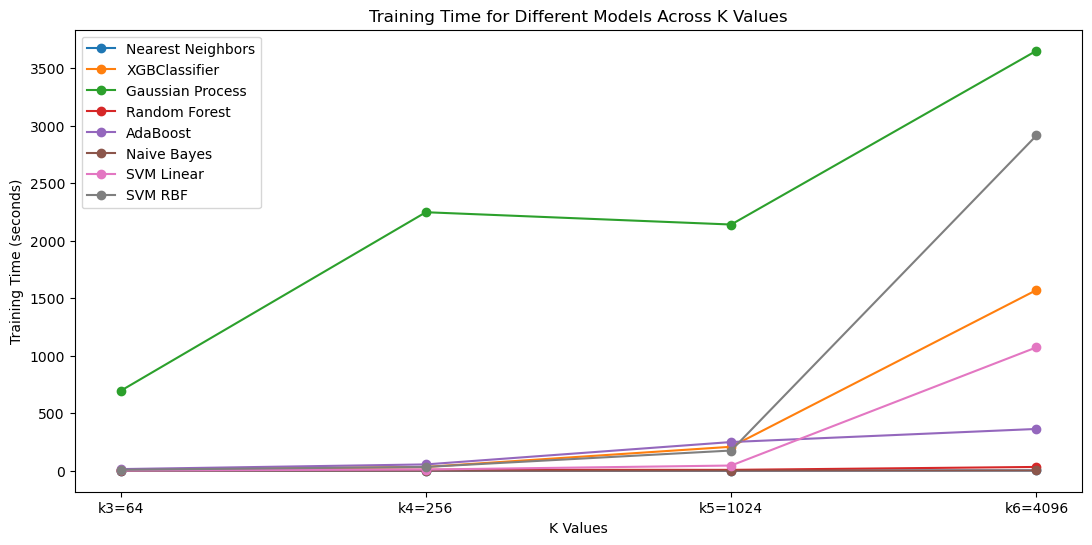

In [45]:
train_times_matrix = np.array([
    history_k3['train_time'],
    history_k4['train_time'],
    history_k5['train_time'],
    history_k6['train_time'],
]).T
fig, ax = plt.subplots(figsize=(13, 6))
k_values = [f'k3={4**3}', f'k4={4**4}', f'k5={4**5}', f'k6={4**6}']
for idx, model in enumerate(names):
    ax.plot(k_values, train_times_matrix[idx], marker='o', label=model)
ax.set_xlabel('K Values')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time for Different Models Across K Values')
ax.legend()
plt.show()

* model performance over k-mer length

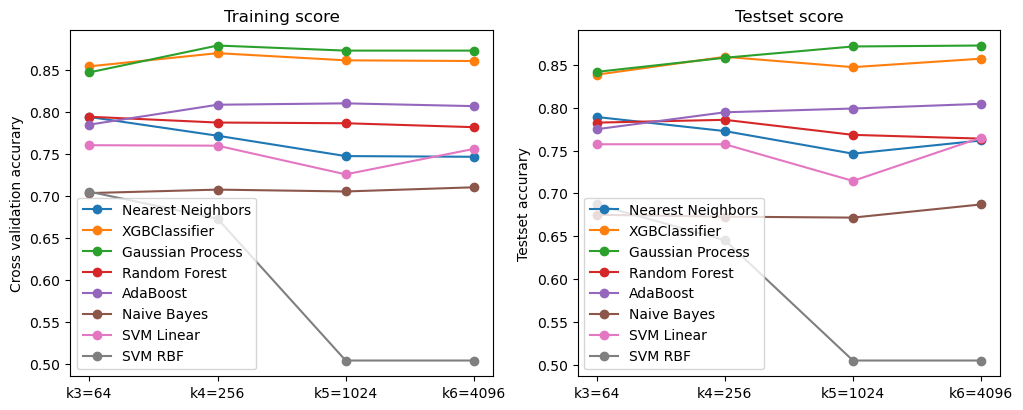

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
train_score = np.array([
    history_k3['train_score'],
    history_k4['train_score'],
    history_k5['train_score'],
    history_k6['train_score'],
]).T
k_values = [f'k3={4**3}', f'k4={4**4}', f'k5={4**5}', f'k6={4**6}']
for idx, model in enumerate(names):
    ax[0].plot(k_values, train_score[idx], marker='o', label=model)
ax[0].set_ylabel('Cross validation accurary')
ax[0].set_title('Training score')
ax[0].legend()

test_score = np.array([
    history_k3['test_score'],
    history_k4['test_score'],
    history_k5['test_score'],
    history_k6['test_score'],
]).T
k_values = [f'k3={4**3}', f'k4={4**4}', f'k5={4**5}', f'k6={4**6}']
for idx, model in enumerate(names):
    ax[1].plot(k_values, test_score[idx], marker='o', label=model)
ax[1].set_ylabel('Testset accurary')
ax[1].set_title('Testset score')
ax[1].legend()
plt.show()

* model performance for each model

In [47]:
df = pd.DataFrame({
    'k3_train_score': history_k3['train_score'],
    'k3_train_score_std': [s[:10] for s in history_k3['train_score_std']],
    'k3_test_score': history_k3['test_score'],
    'k4_train_score': history_k4['train_score'],
    'k4_train_score_std': [s[:10] for s in history_k4['train_score_std']],
    'k4_test_score': history_k4['test_score'],
    'k5_train_score': history_k5['train_score'],
    'k5_train_score_std': [s[:10] for s in history_k5['train_score_std']],
    'k5_test_score': history_k5['test_score'],
    'k6_train_score': history_k6['train_score'],
    'k6_train_score_std': [s[:10] for s in history_k6['train_score_std']],
    'k6_test_score': history_k6['test_score'],
})
iterable = [["k=3", "k=4", "k=5", "k=6"], ["train_score", "train_score_std", "test_score"]]
index = pd.MultiIndex.from_product(iterable, names=["k_mer", "scores"])
df.index = names
df.columns = index

# Highlight best performance for each model
def highlight_best_scores(s):
    if np.issubdtype(s.dtype, np.number):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]
def highlight_best_scores2(s):
    if np.issubdtype(s.dtype, np.number):
        is_max = s == s.max()
        return ['font-weight: bold; color: red' if v else '' for v in is_max]

columns_to_highlight1 = [("k=3", "train_score"), ("k=4", "train_score"), ("k=5", "train_score"), ("k=6", "train_score")]
columns_to_highlight2 = [("k=3", "test_score"), ("k=4", "test_score"), ("k=5", "test_score"), ("k=6", "test_score")]
df_style = df.style.apply(highlight_best_scores, subset=columns_to_highlight1, axis=0)
df_style = df_style.apply(highlight_best_scores2, subset=columns_to_highlight2, axis=0)
display(df_style)

**Note**: Without feature selection, we have obtained our initial results. We also realize that the training time increase as the k-mer length choosen to represente our DNA sequence grow. To enhance these results, we will first attempt to reduce the data dimensions using PCA (Principal Component Analysis). Following that, we will try some traditional feature selection methods.

<h4 style="background-color: #80c4e6; border-top: 4px solid #dddddd; display: flex; color: white;">
    <ul><li>Dimenssion reduction: PCA</li></ul>
</h4>

In this session, we performed dimensionality reduction using PCA. Then, we used the reduced feature space to train and evaluate our model. Since PCA projects our features into a dimension where elements are linearly separable, we tried new models like SVM...

[<span style="padding: .5em; background-color: #dddddd;">Click to Open Notebook for this session</span>](./Notebook/02-sub-notebook-pca.ipynb)

We conducted various tests. Here are the results obtained: (we focus on model perfomance only on training set using cross_validation and on testset(never seen data))

In [37]:
pca_result_k3 = pd.read_csv("./Output/PCA/result_k_3.csv")
pca_result_k4 = pd.read_csv("./Output/PCA/result_k_4.csv")
pca_result_k5 = pd.read_csv("./Output/PCA/result_k_5.csv")
pca_result_k6 = pd.read_csv("./Output/PCA/result_k_6.csv")

In [45]:
df = pd.DataFrame({
    'k3_test_score': pca_result_k3['test_score'],
    'k3_train_score': pca_result_k3['train_score'],
    'k3_train_score_std': [s[:10] for s in pca_result_k3['train_score_std']],
    'k4_test_score': pca_result_k4['test_score'],
    'k4_train_score': pca_result_k4['train_score'],
    'k4_train_score_std': [s[:10] for s in pca_result_k4['train_score_std']],
    'k5_test_score': pca_result_k5['test_score'],
    'k5_train_score': pca_result_k5['train_score'],
    'k5_train_score_std': [s[:10] for s in pca_result_k5['train_score_std']],
    'k6_test_score': pca_result_k6['test_score'],
    'k6_train_score': pca_result_k6['train_score'],
    'k6_train_score_std': [s[:10] for s in pca_result_k6['train_score_std']],
})
pca_model_names = ["GausianProcess", "LogisticRegression", "RandomForestClassifier", "SVC_Linear", "XGBClassifier", "AdaBoostClassifier"]
iterable = [["k=3", "k=4", "k=5", "k=6"], ["test_score", "train_score", "train_score_std"]]
index = pd.MultiIndex.from_product(iterable, names=["k_mer", "scores"])
df.index = pca_model_names
df.columns = index

# Highlight best performance for each model
def highlight_best_scores(s):
    if np.issubdtype(s.dtype, np.number):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]
def highlight_best_scores2(s):
    if np.issubdtype(s.dtype, np.number):
        is_max = s == s.max()
        return ['font-weight: bold; color: red' if v else '' for v in is_max]

columns_to_highlight1 = [("k=3", "train_score"), ("k=4", "train_score"), ("k=5", "train_score"), ("k=6", "train_score")]
columns_to_highlight2 = [("k=3", "test_score"), ("k=4", "test_score"), ("k=5", "test_score"), ("k=6", "test_score")]
df_style = df.style.apply(highlight_best_scores, subset=columns_to_highlight1, axis=0)
df_style = df_style.apply(highlight_best_scores2, subset=columns_to_highlight2, axis=0)
display(df_style)

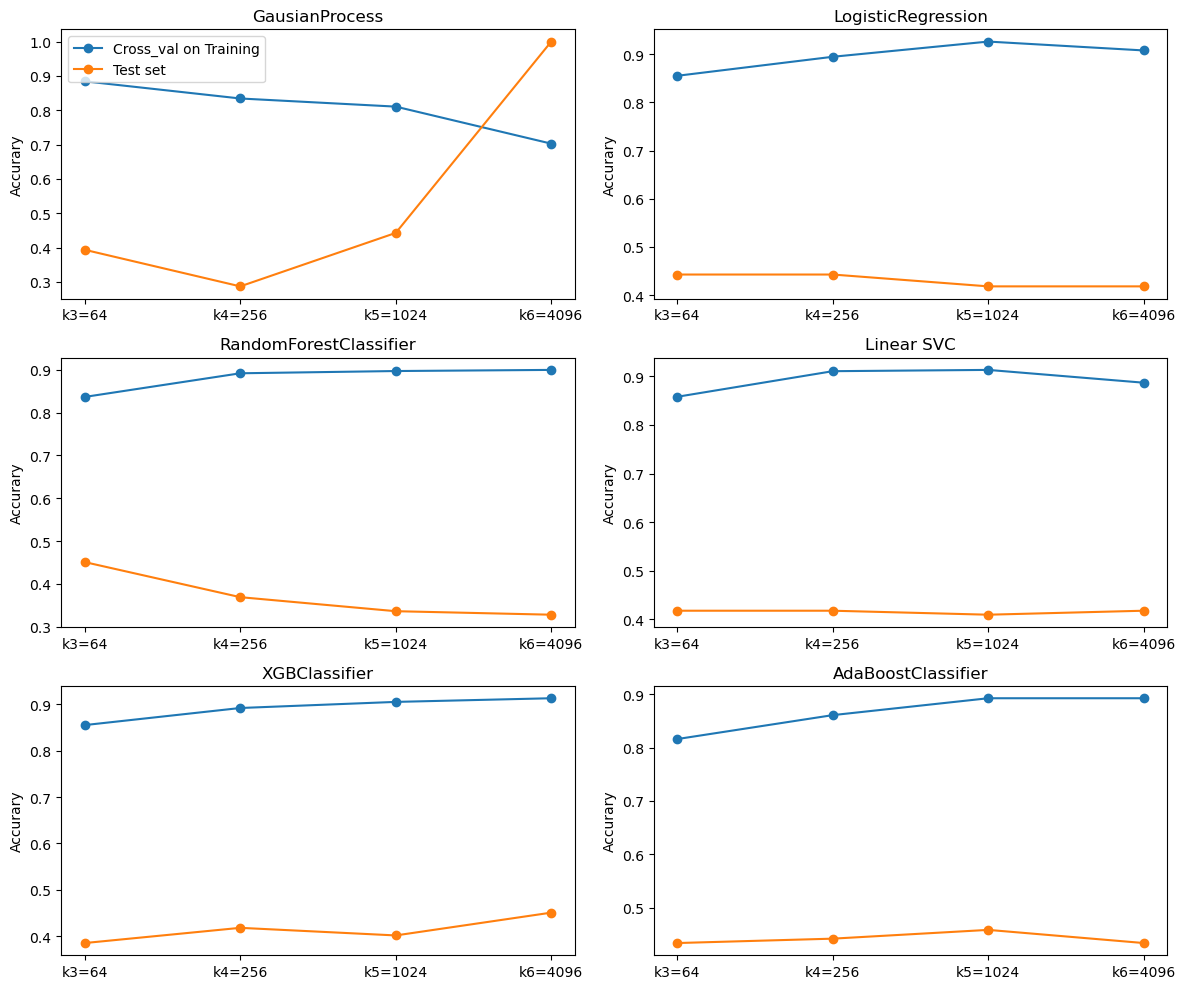

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
ax = ax.flatten()
k_values = [f'k3={4**3}', f'k4={4**4}', f'k5={4**5}', f'k6={4**6}']
pca_model_names = ["GausianProcess", "LogisticRegression", "RandomForestClassifier", "Linear SVC", "XGBClassifier", "AdaBoostClassifier"]
train_score = np.array([
    pca_result_k3['train_score'].tolist(),
    pca_result_k4['train_score'].tolist(),
    pca_result_k5['train_score'].tolist(),
    pca_result_k6['train_score'].tolist(),
]).T
test_score = np.array([
    pca_result_k3['test_score'].tolist(),
    pca_result_k4['test_score'].tolist(),
    pca_result_k5['test_score'].tolist(),
    pca_result_k6['test_score'].tolist(),
]).T

for idx, model in enumerate(pca_model_names):
    ax[idx].plot(k_values, train_score[idx], marker='o', label="Cross_val on Training")
    ax[idx].plot(k_values, test_score[idx], marker='o', label="Test set")
    ax[idx].set_ylabel('Accurary')
    ax[idx].set_title(model)
ax[0].legend(loc='upper left')
plt.tight_layout()
plt.show()

**Note**: Logistic regression and AdaBoost seems to be the best model we have.

<h4 style="background-color: #80c4e6; border-top: 4px solid #dddddd; display: flex; color: white;">
    <ul><li>Features Selection: Statistical and Model based approach</li></ul>
</h4>

<img src="./Content/Notebook-images/feature_selection.png" alt="freatures selection"/>

Based on the previously trained models, we rely on k-mer representations (3, 4, 5, 6). For k=3, we have 4^3 features, or 64 features. However, starting from k=4, we have 256 features, which become too many. Among these, there are features that are not necessarily correlated with the target. Therefore, it is necessary to select the most relevant features to reduce the training time and consequently improve performance.

* Approach
  
We have tried different usual feature selection methods such as F-Test, variance-based (statistical approach), model-based feature selection approaches like Random Forest, Lasso, Ridge, RFE, and also a specific feature selection approach for k-mers in DNA sequences introduced in the literature. Here is the link to the paper: https://www.researchgate.net/publication/268977663_A_new_feature_selection_strategy_for_K-mers_sequence_representation

[<span style="padding: .5em; background-color: #dddddd;">Click to Open Notebook for this session</span>](./Notebook/02-sub-notebook-feature-selection.ipynb)

We conducted various tests. Here are the results obtained: (we focus on model perfomance only on training set using cross_validation and on testset(never seen data))

In [57]:
fs_result_k3 = pd.read_csv("./Output/FSelect/result_k_3.csv")
fs_result_k4 = pd.read_csv("./Output/FSelect/result_k_4.csv")
fs_result_k5 = pd.read_csv("./Output/FSelect/result_k_5.csv")
fs_result_k6 = pd.read_csv("./Output/FSelect/result_k_6.csv")

In [58]:
# Define a function to highlight the max values in test_score with a light yellow background
def highlight_test_score(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Define a function to highlight the max values in train_score with bold and red color
def highlight_train_score(s):
    is_max = s == s.max()
    return ['color: red; font-weight: bold' if v else '' for v in is_max]

# Define a function to style the DataFrame
def highlight_dataframe(df):
    styled_df = df.style.apply(highlight_test_score, subset=['test_score'])
    styled_df = styled_df.apply(highlight_train_score, subset=['train_score'])
    return styled_df

**Interpretation Guideline**: Rows with the highest test scores are highlighted with a yellow background, and rows with the highest train scores are highlighted in red. You can see the results for various k-mer lengths.

* k = 3

In [59]:
k_3 = fs_result_k3[['name', 'test_score', 'train_score', 'train_std_score', 'train_precision', 
                    'train_recall', 'train_f1', 'feature_selection_method', 'k-mer size']]
styled_df = highlight_dataframe(k_3)
display(styled_df)

,name,test_score,train_score,train_std_score,train_precision,train_recall,train_f1,feature_selection_method,k-mer size
0,GaussianProcessClassifier,0.614754,0.876316,±0.03730907073357322,0.881466,0.912554,0.893904,No,3
1,RandomForestClassifier,0.811475,0.847368,±0.05741427428755639,0.862368,0.880736,0.869320,No,3
2,AdaBoostClassifier,0.721311,0.857895,±0.05545080922554074,0.865864,0.898918,0.879727,No,3
3,GaussianNB,0.844262,0.815789,±0.06657426652986062,0.862924,0.812338,0.833468,No,3
4,GaussianProcessClassifier,0.614754,0.876316,±0.03730907073357322,0.881466,0.912554,0.893904,Variance-based(1),3
5,RandomForestClassifier,0.795082,0.855263,±0.06143482910488815,0.877113,0.876190,0.874622,Variance-based(1),3
6,AdaBoostClassifier,0.721311,0.857895,±0.05545080922554074,0.865864,0.898918,0.879727,Variance-based(1),3
7,GaussianNB,0.844262,0.815789,±0.06657426652986062,0.862924,0.812338,0.833468,Variance-based(1),3
8,GaussianProcessClassifier,0.737705,0.834211,±0.06006690637112278,0.836397,0.889827,0.860832,FTest,3
9,RandomForestClassifier,0.754098,0.828947,±0.0567469964548627,0.840544,0.871645,0.854082,FTest,3


* k = 4

In [60]:
k_4 = fs_result_k4[['name', 'test_score', 'train_score', 'train_std_score', 'train_precision', 
                    'train_recall', 'train_f1', 'feature_selection_method', 'k-mer size']]
styled_df = highlight_dataframe(k_4)
display(styled_df)

,name,test_score,train_score,train_std_score,train_precision,train_recall,train_f1,feature_selection_method,k-mer size
0,GaussianProcessClassifier,0.647541,0.907895,±0.055513218709813135,0.916494,0.925974,0.919853,No,4
1,RandomForestClassifier,0.762295,0.878947,±0.03938586722919938,0.874625,0.925974,0.897545,No,4
2,AdaBoostClassifier,0.795082,0.881579,±0.04887940952896502,0.875992,0.926190,0.899377,No,4
3,GaussianNB,0.885246,0.844737,±0.04152561536331448,0.891306,0.834848,0.859553,No,4
4,GaussianProcessClassifier,0.647541,0.907895,±0.055513218709813135,0.916494,0.925974,0.919853,Variance-based(1),4
5,RandomForestClassifier,0.795082,0.886842,±0.0456561883497302,0.885118,0.925974,0.903373,Variance-based(1),4
6,AdaBoostClassifier,0.795082,0.881579,±0.04887940952896502,0.875992,0.926190,0.899377,Variance-based(1),4
7,GaussianNB,0.885246,0.844737,±0.04152561536331448,0.891306,0.834848,0.859553,Variance-based(1),4
8,GaussianProcessClassifier,0.737705,0.873684,±0.06315789473684211,0.879470,0.908009,0.892290,FTest,4
9,RandomForestClassifier,0.778689,0.871053,±0.05322039056883339,0.878515,0.903463,0.889161,FTest,4


* k = 5

In [61]:
k_5 = fs_result_k5[['name', 'test_score', 'train_score', 'train_std_score', 'train_precision', 
                    'train_recall', 'train_f1', 'feature_selection_method', 'k-mer size']]
styled_df = highlight_dataframe(k_5)
display(styled_df)

,name,test_score,train_score,train_std_score,train_precision,train_recall,train_f1,feature_selection_method,k-mer size
0,GaussianProcessClassifier,0.647541,0.905263,±0.0657368210357726,0.902944,0.940043,0.919708,No,5
1,RandomForestClassifier,0.778689,0.894737,±0.04076824574955174,0.883169,0.949351,0.912799,No,5
2,AdaBoostClassifier,0.795082,0.894737,±0.05263157894736841,0.907915,0.912554,0.908527,No,5
3,GaussianNB,0.868852,0.852632,±0.04736842105263157,0.874543,0.871861,0.871445,No,5
4,GaussianProcessClassifier,0.647541,0.905263,±0.0657368210357726,0.902944,0.940043,0.919708,Variance-based(1),5
5,RandomForestClassifier,0.754098,0.889474,±0.05236775984771682,0.868316,0.958442,0.909813,Variance-based(1),5
6,AdaBoostClassifier,0.795082,0.894737,±0.05263157894736841,0.907915,0.912554,0.908527,Variance-based(1),5
7,GaussianNB,0.868852,0.852632,±0.04736842105263157,0.874543,0.871861,0.871445,Variance-based(1),5
8,GaussianProcessClassifier,0.811475,0.913158,±0.05136637183142931,0.920241,0.935281,0.925197,FTest,5
9,RandomForestClassifier,0.795082,0.902632,±0.04251445900369346,0.899151,0.940043,0.917349,FTest,5


* k = 6

In [62]:
k_6 = fs_result_k6[['name', 'test_score', 'train_score', 'train_std_score', 'train_precision', 
                    'train_recall', 'train_f1', 'feature_selection_method', 'k-mer size']]
styled_df = highlight_dataframe(k_6)
display(styled_df)

,name,test_score,train_score,train_std_score,train_precision,train_recall,train_f1,feature_selection_method,k-mer size
0,GaussianProcessClassifier,0.663934,0.907895,±0.06255191749476163,0.907046,0.944589,0.923310,No,6
1,RandomForestClassifier,0.713115,0.831579,±0.04275809686650505,0.796828,0.953896,0.867328,No,6
2,AdaBoostClassifier,0.893443,0.884211,±0.029304022962263265,0.886074,0.922078,0.900979,No,6
3,GaussianNB,0.663934,0.847368,±0.05102820902543503,0.839797,0.912771,0.873113,No,6
4,GaussianProcessClassifier,0.663934,0.907895,±0.06255191749476163,0.907046,0.944589,0.923310,Variance-based(1),6
5,RandomForestClassifier,0.729508,0.842105,±0.031137262016313772,0.828354,0.926190,0.871071,Variance-based(1),6
6,AdaBoostClassifier,0.893443,0.884211,±0.029304022962263265,0.886074,0.922078,0.900979,Variance-based(1),6
7,GaussianNB,0.663934,0.847368,±0.05102820902543503,0.839797,0.912771,0.873113,Variance-based(1),6
8,GaussianProcessClassifier,0.778689,0.947368,±0.03721614637823934,0.943375,0.967749,0.955011,FTest,6
9,RandomForestClassifier,0.844262,0.897368,±0.018421052631578925,0.899511,0.926407,0.911980,FTest,6
